## Генерация полифонической музыки с кондишнингом

В этой версии используется VAE. Энкодер -- двухслойная полносвязная нейронная сеть, декодер -- зеркальная двухслойная полносвязная нейронная сеть.

Импортируем torch и numpy:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random

Сделаем также пользовательский импорт

In [2]:
from decode_patterns import data_conversion

In [3]:
data_height = 64
drum_width = 14
melody_width = 36
data_width = drum_width + melody_width
data_size = data_height*data_width
train_file = "decode_patterns/train.tsv" # обучающая выборка
validation_file = "decode_patterns/validation.tsv" # валидационная выборка
human_file = "decode_patterns/human.tsv" # как валидационная, только для ассесмента людей (read as "validation")

Загружаем датасет

In [5]:
# import dataset
drum, bass = data_conversion.make_lstm_dataset_conditioning(height=data_height,
                                                            patterns_file=train_file,
                                                            mono=False)

# define shuffling of dataset
def shuffle(A, B, p=0.8):
    # take 80% to training, other to testing
    AB = list(zip(A, B))
    L = len(AB)
    pivot = int(p*L)
    random.shuffle(AB)
    yield [p[0] for p in AB[:pivot]]
    yield [p[1] for p in AB[:pivot]]
    yield [p[0] for p in AB[pivot:]]
    yield [p[1] for p in AB[pivot:]]
    
    
# we can shuffle train and test set like this:
drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)

# selecting a validation set
drum_validation, bass_validation = data_conversion.make_lstm_dataset_conditioning(height=data_height,
                                                                                  patterns_file=validation_file,
                                                                                  mono=False)

In [6]:
bass[16]

NumpyImage(image=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), tempo=96, instrument=27, denominator=4, min_note=45)

Модель определим в самом простом варианте, который только можно себе представить -- как в примере с конечным автоматом

In [7]:
# Encoder = LSTM
# Decoder = FCNN
class DrumNBass_FFNN_to_FFNN(nn.Module):
    
    def __init__(self, data_height, drum_width, melody_width):
        super(DrumNBass_FFNN_to_FFNN, self).__init__()
        
        self.data_height = data_height
        self.drum_width = drum_width
        self.melody_width = melody_width
        self.condition_size = 2 # размер подмешиваемого conditioning
        
        input_dim = data_height*drum_width
        latent_dim = 4
        hidden_dim = (input_dim + 2*latent_dim) // 3
        output_dim = data_height*melody_width
        
        # Linear function 1: 128 * 14 = 1792 --> 2048
        # веса накидываются тут
        self.fc1 = nn.Linear(input_dim + self.condition_size, hidden_dim)
#         nn.init.normal_(self.fc1.weight, mean=1.5, std=1.0)
        # решение по весам
        self.relu1 = nn.Sigmoid()
        
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         nn.init.normal_(self.fc2.weight, mean=1.5, std=1.0)
        self.relu2 = nn.Sigmoid()


        # Linear function 31: 2048 --> 4
        # для средних значений
        self.fc31 = nn.Linear(hidden_dim, latent_dim)
        # Non-linearity 31
        self.relu31 = nn.Sigmoid()
        
        
        # Linear function 22: 2048 --> 4
        # для стандартных отклонений
        self.fc32 = nn.Linear(hidden_dim, latent_dim)
        # Non-linearity 22
        self.relu32 = nn.Sigmoid()

        # Linear function 4: 4 --> 2048
        self.fc4 = nn.Linear(latent_dim + self.condition_size, hidden_dim)
#         nn.init.normal_(self.fc4.weight, mean=1.5, std=1.0)
        # Non-linearity 4
        self.relu4 = nn.Sigmoid()
        
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
#         nn.init.normal_(self.fc5.weight, mean=1.5, std=1.0)
        self.relu5 = nn.Sigmoid()

        # Linear function 6 (readout): 2048 --> 128 * 36 = 4608
        self.fc6 = nn.Linear(hidden_dim, output_dim)  
        self.sigmoid = nn.Sigmoid()
        
    def encoder(self, x, cond):
        out = torch.cat((x, cond), axis=1) # добавляем conditioning
        # Linear function 1
        out = self.fc1(out)
        # Non-linearity 1
        out = self.relu1(out)
        
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 31
        mu = self.fc31(out)
        # Non-linearity 31
        mu = self.relu31(mu)
        
        
        # Linear function 22
        logvar = self.fc32(out)
        # Non-linearity 22
        logvar = self.relu32(logvar)
        
        return mu, logvar
    
    # reference:
    # https://github.com/pytorch/examples/blob/master/vae/main.py
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    # end reference
    
    def decoder(self, x, cond):
        out = torch.cat((x, cond), axis=1) # добавляем conditioning
        # Linear function 4
        out = self.fc4(out)
        # Non-linearity 4
        out = self.relu4(out)
        
        # Linear function 5
        out = self.fc5(out)
        # Non-linearity 5
        out = self.relu5(out)

        # Linear function 6 (readout)
        out = self.fc6(out)
        out = self.sigmoid(out)
        return out
    
    @staticmethod
    def get_images(input):
        return torch.tensor(list(map(lambda p: p.image.flatten(), input)), dtype=torch.float)
    
    @staticmethod
    def get_conditionings(input):
        return torch.tensor(list(map(lambda p: [p.tempo, p.instrument], input)), dtype=torch.float)
    
    def forward(self, x):
        # добавляем conditioning
        conditionings = self.get_conditionings(x)
        images = self.get_images(x)
        mean, logvar = self.encoder(images, conditionings)
        # генерируем случайную точку в латентном пространстве
        result = self.reparameterize(mean, logvar)
        result = self.decoder(result, conditionings)
        return result.view((-1, self.data_height, self.melody_width)), mean, logvar

In [8]:
# часть обучения
dnb_ffnn = DrumNBass_FFNN_to_FFNN(data_height, drum_width, melody_width)

# criterion = nn.MSELoss() # -- с этим всё работает (точнее, работало)
# criterion = nn.NLLLoss() # -- этот товарищ требует, чтобы LSTM выдавал классы,
# criterion = nn.CrossEntropyLoss() # и этот тоже
# (числа от 0 до C-1), но как всё-таки его заставить это делать?...

# оценим также и разнообразие мелодии по её.. дисперсии?)
# def melody_variety(melody):
#     return 1/(1 + (melody.sum(axis=2) > 1).int())

# на самом деле, попробуем функцию потерь взять из VAE

# Reference: https://github.com/pytorch/examples/blob/master/vae/main.py
# Reconstruction + KL divergence losses summed over all elements and batch
def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

def reconstruction_KL_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

optimizer = optim.Adam(dnb_ffnn.parameters(), lr=0.001)
# optimizer = optim.SGD(dnb_ffnn.parameters(), lr=0.001, momentum=0.9)

Посмотрим, как модель форвардится на один пример

In [9]:
dnb_ffnn.forward([drum_validation[16], drum_validation[14], drum_validation[43]])[0].size()

torch.Size([3, 64, 36])

In [10]:
bass_validation[16].image.shape

(64, 36)

Найденные баги и их решения:

https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ

https://stackoverflow.com/questions/49206550/pytorch-error-multi-target-not-supported-in-crossentropyloss/49209628

https://stackoverflow.com/questions/56243672/expected-target-size-50-88-got-torch-size50-288-88

In [11]:
epoch_count = 35
batch_size = 16
shuffle_every_epoch = True
    
if shuffle_every_epoch:
    print(f"shuffle_every_epoch is on")
else:
    print(f"shuffle_every_epoch is off")
    # shuffle train and test set:
    drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)
        
for epoch in range(epoch_count):  # loop over the dataset multiple times
    print(f"Epoch #{epoch}")
    if shuffle_every_epoch:
        # shuffle train and test set:
        drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)
        
    examples_count = len(drum_train)
    examples_id = 0
    
    running_loss = 0.0
    runnint_count = 0
    batch_id = 0
    while examples_id < examples_count:
        batch_drum_train = drum_train[examples_id:examples_id + batch_size]
        batch_bass_train = bass_train[examples_id:examples_id + batch_size]
        
        batch_bass_train_raw = torch.tensor(list(map(lambda p: p.image, batch_bass_train)), dtype=torch.float)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        bass_outputs, mu, stddev = dnb_ffnn(batch_drum_train)
        # bass_outputs = bass_outputs.squeeze()
        
        # loss = criterion(bass_outputs, batch_bass_train_raw)
        loss = 0
        for i in range(batch_size):
            loss += reconstruction_KL_loss_function(bass_outputs[i], batch_bass_train_raw[i], mu[i], stddev[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        runnint_count += 1
        period = 5
        if batch_id % period == 0 or examples_id + batch_size >= examples_count:
            print('[%d, %5d] train loss: %.7f' %
                  (epoch + 1, batch_id + 1, running_loss / runnint_count))
            running_loss = 0.0
            runnint_count = 1
            
        # update batch info
        examples_id += batch_size
        batch_id += 1
        
    # here we can insert measure error on test set
    with torch.no_grad():
        batch_bass_test_raw = torch.tensor(list(map(lambda p: p.image, bass_test)), dtype=torch.float)
        bass_outputs, _, _ = dnb_ffnn(drum_test)
        
        test_count = len(drum_test)
        test_loss = 0
        for k in range(test_count):
            test_loss += reconstruction_loss(bass_outputs[k], batch_bass_test_raw[k])
        print(f"#{epoch + 1} reconstruction test loss: {test_loss/test_count}")
    

#should check accuracy on validation set
with torch.no_grad():
    batch_bass_validation_raw = torch.tensor(list(map(lambda p: p.image, bass_validation)), dtype=torch.float)
    bass_outputs, _, _ = dnb_ffnn(drum_test)

    validation_count = len(drum_test)
    validation_loss = 0
    for k in range(validation_count):
        validation_loss += reconstruction_loss(bass_outputs[k], batch_bass_validation_raw[k])
    print(f"#{epoch + 1} reconstruction validation loss: {validation_loss/validation_count}")
print('Finished Training')

shuffle_every_epoch is on
Epoch #0
[1,     1] train loss: 26007.4667969
[1,     6] train loss: 15319.2210286
[1,    11] train loss: 6760.9116211
[1,    16] train loss: 2677.7970785
[1,    21] train loss: 1886.4801432
[1,    26] train loss: 1620.8393351
[1,    31] train loss: 1517.1423136
[1,    36] train loss: 1621.6326294
[1,    41] train loss: 1696.4822795
[1,    46] train loss: 1562.4137980
[1,    51] train loss: 1462.6774292
[1,    56] train loss: 1460.3236491
[1,    61] train loss: 1466.0707601
[1,    66] train loss: 1503.2029012
[1,    71] train loss: 1560.3666789
[1,    76] train loss: 1403.7815145
[1,    81] train loss: 1458.6035360
[1,    86] train loss: 1465.6116943
[1,    91] train loss: 1357.8545736
[1,    96] train loss: 1555.1640422
[1,   101] train loss: 1560.8454793
[1,   106] train loss: 1395.5764364
[1,   111] train loss: 1432.3311361
[1,   116] train loss: 1435.4966227
[1,   121] train loss: 1577.8641968
[1,   126] train loss: 1467.0599162
[1,   131] train loss: 1433

KeyboardInterrupt: 

### Этап эксплуатации нейросети
Посмотрим на результаты, что выдаёт нейросеть на выходе...

In [12]:
with torch.no_grad():
    bass_outputs = dnb_ffnn(drum_train)
result = bass_outputs[0].squeeze().int()
# result

Однако, более интересно посмотреть на то, что получилось в латентном пространстве... Неплохо было бы визуализировать точки в латентном пространстве

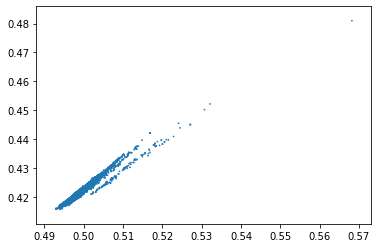

In [15]:
with torch.no_grad():
    latent_train = dnb_ffnn.encoder(dnb_ffnn.get_images(drum_train), dnb_ffnn.get_conditionings(drum_train))
    
mu, dev = latent_train
mu
# libraries
import matplotlib.pyplot as plt
import numpy as np
 
# create data
x = mu[:,0]*100
y = mu[:,1]*100
z = dev
 
# use the scatter function
plt.scatter(x, y, s=z*100)
plt.show()


Попробуем сохранить результаты работы сети. На anaconda нет mido, поэтому сохраняем результаты работы просто в массивчик npy... Однако, как альтернатива, его можно поставить чере pip в conda:
https://github.com/mido/mido/issues/198

In [16]:
import mido
from decode_patterns.data_conversion import build_track, DrumMelodyPair, NumpyImage, Converter


converter = Converter((data_height, data_width))

def output_midi(batch_drum, batch_bass, folder):
    with torch.no_grad():
        bass_outputs = dnb_ffnn(batch_drum)[0]
        bass_outputs = ((bass_outputs.squeeze() + 1) / 2 > 0.55).int()

        for i in range(len(batch_drum)):

            img_dnb = np.concatenate((batch_drum[i].image,bass_outputs[i]), axis=1)
            numpy_pair = NumpyImage(np.array(img_dnb)
                                    , batch_drum[i].tempo
                                    , batch_drum[i].instrument
                                    , 1
                                    , batch_drum[i].min_note)
            pair = converter.convert_numpy_image_to_pair(numpy_pair)
            mid = build_track(pair, tempo=pair.tempo)
            mid.save(f"{folder}/sample{i+1}.mid")

Выводим обучающую и валидационную выборку

In [ ]:
# # если очень надо послушать тренировчную -- лучше её перезагрузить, потому что она перемешивается
# drum, bass = data_conversion.make_lstm_dataset_conditioning(height=data_height,
#                                                             patterns_file=train_file,
#                                                             mono=False)
# output_midi(drum_train + drum_test, bass_train + bass_test, "midi/vae_fcnn_fcnn/train")
output_midi(drum_validation, bass_validation, "midi/vae_fcnn_fcnn/validation")

По вкусу, выводим тот же результат для кожанных мешков на ассесмент. На самом деле ничем от валидационной выборки не отличается :)

In [20]:
drum_hum, bass_hum = data_conversion.make_lstm_dataset_conditioning(height=data_height, patterns_file=human_file, mono=False)
output_midi(drum_hum, bass_hum, "midi/vae_fcnn_fcnn/human")

Попробуем сделать градиент от двух базовых партий!

In [31]:
# sample1_id = 89
# sample2_id = 49

steps = 10 # количество шагов между семплами
sample1_id = 55
sample2_id = 119
sample1 = drum_validation[sample1_id]
sample2 = drum_validation[sample2_id]

# вычисляем два вектора в латентном пространстве
with torch.no_grad():
    sampls = [sample1, sample2]
    latent_train = dnb_ffnn.encoder(dnb_ffnn.get_images(sampls), dnb_ffnn.get_conditionings(sampls))
    mu, dev = latent_train

    sample1_latent = mu[0]
    sample2_latent = mu[1]
    
    # пробегаемся линейно по латентному пространству
    for step in range(steps + 1):
        alpha = step / steps
        latent_sample = sample1_latent + (sample2_latent - sample1_latent)*alpha
        
        # пока что выбираем соответствующую барабанную партию в двоичном виде
        drum_sample = sample1
        if (alpha >= 0.5):
            drum_sample = sample2
            
        # а параметры для кондишнинга -- линейно
        tempo = sample1.tempo + (sample2.tempo - sample1.tempo) * alpha
        # instrument = sample1.instrument + (sample2.instrument - sample1.instrument) * alpha
        instrument = drum_sample.instrument
        
        # декодируем линейную комбинацию
        conditionings = torch.tensor([tempo, instrument]).float()
        upsample = dnb_ffnn.decoder(latent_sample.unsqueeze(dim=0), conditionings.unsqueeze(dim=0))
        upsample =  upsample.view((data_height, melody_width))
        upsample = ((upsample.squeeze() + 1) / 2 > 0.55)
        
        
        # сохраняем в файл
        img_dnb = np.concatenate((drum_sample.image,upsample), axis=1)
        numpy_pair = NumpyImage(np.array(img_dnb)
                                , tempo
                                , int(instrument)
                                , 1
                                , drum_sample.min_note)
        pair = converter.convert_numpy_image_to_pair(numpy_pair)
        mid = build_track(pair, tempo=pair.tempo)
        mid.save(f"midi/vae_fcnn_fcnn/grad/gradient{step}.mid")
        
